# Customer Clustering Using K-Means for Route Optimization

This section performs customer clustering based on geographical coordinates using the K-Means algorithm.
The goal is to group nearby customers together to support optimized delivery routes in Estonia.

---

## Step 1 – Load Preprocessed Customer Data

In this step, we load a cleaned customer delivery dataset from the `Processed_data` directory. The file is expected to include columns such as full address, service type, and geocoded latitude/longitude coordinates.


In [7]:
# === START SECTION ===
# Imports and data loading
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from kneed import KneeLocator # For elbow method detection
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import os
import sys
import chardet  # Library for automatic character encoding detection
from pathlib import Path

warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Paths and folder setup
project_root = Path.cwd() # Current working directory of the notebook
input_path = project_root.parent / '02 Data' / '01_processed_data'
output_path = input_path # That is okay

# Check if input directory exists
if not input_path.exists():
    print(f"Error: Input directory '{input_path}' does not exist.")
    print("Please create this directory or modify the path.")
    sys.exit(1)

# Create output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)
print(f"Project setup complete. \n Input path: {input_path} \n Output path: {output_path}")

Project setup complete. 
 Input path: C:\Users\User\Dropbox\Personal\CareerFoundry\06 Sourcing data\Notebook folder\02 Data\01_processed_data 
 Output path: C:\Users\User\Dropbox\Personal\CareerFoundry\06 Sourcing data\Notebook folder\02 Data\01_processed_data


## Step 2 – Map Relevant Columns and Preprocess Data

We map relevant columns such as latitude, longitude, customer ID, and address to standardized names used in clustering.
This step ensures flexibility if column names vary between datasets. We also optionally include additional columns (e.g., service type) for richer cluster summaries.

---

In [8]:
# File selection and CSV loading
from IPython.display import display  # For showing DataFrames in Jupyter

# 1. List available CSV files in the input directory
available_files = list(input_path.glob("*.csv"))
if not available_files:
    print(f"No CSV files found in {input_path}")

print("Available files:")
for i, f in enumerate(available_files, start=1):
    print(f"{i}: {f.name}")

# 2. Prompt user to choose a file by number
while True:
    try:
        choice = int(input(f"Choose file number (1-{len(available_files)}): ").strip()) - 1
        if 0 <= choice < len(available_files):
            break
        print(f"Please enter a number between 1 and {len(available_files)}")
    except ValueError:
        print("Please enter a valid number.")

file_path = available_files[choice]

# 3. Detect file encoding
print(f"Detecting encoding for {file_path.name}...")
with open(file_path, 'rb') as file:
    result = chardet.detect(file.read())
encoding = result['encoding']
confidence = result['confidence']
print(f"Detected encoding: {encoding} (confidence: {confidence:.1%})")

# 4. Analyze delimiter options
print("\nAnalyzing potential delimiters:\n")
delimiters = [',', ';', r'\t', '|']  # Raw string for tab to avoid escape issues
delimiter_options = {}
for i, delim in enumerate(delimiters, start=1):
    try:
        preview_df = pd.read_csv(file_path, engine='python', encoding=encoding, sep=delim, nrows=3)
        col_count = len(preview_df.columns)
        delimiter_options[i] = (delim, col_count)
        print(f"{i}: Delimiter '{delim}'\n   Found {col_count} columns")
        print(f"   Preview with option {i}:")
        display(preview_df.style.set_properties(**{
            'border': '1px solid black', 'padding': '5px', 'text-align': 'left',
            'white-space': 'nowrap', 'overflow': 'hidden', 'text-overflow': 'ellipsis'
        }))
        print("-" * 80 + "\n")
    except Exception as e:
        print(f"{i}: Error with delimiter '{delim}': {e}")

# Suggest the delimiter with the most columns
if delimiter_options:
    suggested = max(delimiter_options, key=lambda k: delimiter_options[k][1])
    print(f"Suggested option: {suggested} ('{delimiter_options[suggested][0]}') with {delimiter_options[suggested][1]} columns")
else:
    print("No valid delimiters found. Please check the file format.")
    sys.exit(1)

# 5. Prompt user to choose delimiter option
while True:
    try:
        delim_choice = input(f"\nChoose delimiter option (1-{len(delimiter_options)}) [default: {suggested}]: ").strip()
        if not delim_choice:
            delim_choice = suggested
        else:
            delim_choice = int(delim_choice)
        if delim_choice in delimiter_options:
            break
        print(f"Please enter a number between 1 and {len(delimiter_options)} or press Enter for default.")
    except ValueError:
        print("Please enter a valid number or press Enter for default.")

chosen_delim, _ = delimiter_options[delim_choice]
print(f"Using delimiter: '{chosen_delim}'")

# 6. Load the full CSV with chosen delimiter and encoding
try:
    df = pd.read_csv(file_path, encoding=encoding, sep=chosen_delim)
    print(f"\n✅ Loaded {df.shape[0]} rows × {df.shape[1]} columns from {file_path.name}")
except Exception as e:
    print(f"❌ Failed to load CSV: {e}")
    sys.exit(1)

# 7. Display data overview
print("\nData Overview:")
print(f"Column names: {', '.join(df.columns[:5])}, ... (and {len(df.columns)-5} more columns)" if len(df.columns) > 5 else f"Column names: {', '.join(df.columns)}")
print(f"\nData types (first 5 columns):\n{df.dtypes[:5]}")
print(f"... (and {len(df.columns)-5} more columns)" if len(df.columns) > 5 else "")
print("\nSample data:")
display(df.head().style.set_properties(**{
    'border': '1px solid black', 'padding': '5px', 'text-align': 'left',
    'white-space': 'nowrap', 'overflow': 'hidden', 'text-overflow': 'ellipsis'
}))

# Function to extract middle digits from Route Number
def extract_middle_digits(route_number):
    # Handle null/NaN values
    if pd.isna(route_number):
        return "00"
    
    # Convert to string to ensure we can access positions
    route_str = str(int(route_number))  # Convert to int first to remove decimal places
    
    # Check if the string has at least 3 characters
    if len(route_str) >= 3:
        # Extract positions 2 and 3 (index 1 and 2 in zero-based indexing)
        return route_str[1:3]
    elif len(route_str) == 2:
        # If only 2 digits, return both
        return route_str
    elif len(route_str) == 1:
        # If only 1 digit, return with a leading zero
        return "0" + route_str
    else:
        # Handle any other cases
        return "00"

# Function to convert first digit of Route Number to weekday
def get_delivery_weekday(route_number):
    # Handle null/NaN values
    if pd.isna(route_number):
        return "Unknown"
    
    # Convert to string and get first digit
    route_str = str(int(route_number))
    
    if len(route_str) > 0:
        first_digit = int(route_str[0])
        
        # Map digit to weekday
        weekday_map = {
            1: "Monday",
            2: "Tuesday",
            3: "Wednesday",
            4: "Thursday",
            5: "Friday",
            6: "Saturday",
            7: "Sunday"
        }
        
        return weekday_map.get(first_digit, "Unknown")
    else:
        return "Unknown"

Available files:
1: 00_work_time_and_km_aggregated.csv
2: 01_weekly_deliveries_clean.csv
3: 02_weekly_deliveries_geocoded.csv
4: 03_1_depot_centered_clusters_ORG.csv
5: 03_2_customer_centered_clusters.csv
6: 05_merged_data.csv
7: 06_clean_agregated_data.csv
8: 06_clean_agregated_data_for Tableau.csv
9: 90_weekly_deliveries_clean.csv
10: 90_work_time_and_km_clean_aggregated.csv


Choose file number (1-10):  3


Detecting encoding for 02_weekly_deliveries_geocoded.csv...
Detected encoding: UTF-8-SIG (confidence: 100.0%)

Analyzing potential delimiters:

1: Delimiter ','
   Found 1 columns
   Preview with option 1:


,,,,,,ABS Custumer no;Route Number;Full address;Service;DeliveryQty;Net Weight;latitude;longitude;formatted_address;geocode_confidence;is_depot;depot_id;depot_name;depot_address
;;;;;;59.36361;27.431;Linda 15f,Jõhvi,41536 Ida-Viru Maakond,Eesti;1.0;TRUE;4.0;Warehouse JÕHVI;Linda tänav 15f,Jõhvi,41536 Ida-Viru maakond,Estonia
;;;;;;58.40743;24.48474;Kõrtsi 7,Pärnu,80034 Pärnu Maakond,Eesti;0.91;TRUE;3.0;Warehouse PÄRNU;Kõrtsi tn 7,Pärnu,80010 Pärnu maakond,Estonia
;;;;;;-23.28398;-51.28932;Rua Estônia,Cambé - PR,86181-410,Brasil;0.95;TRUE;2.0;Production TARTU;Vabriku tn 7,Vahi,60534 Tartu maakond,Estonia


--------------------------------------------------------------------------------

2: Delimiter ';'
   Found 14 columns
   Preview with option 2:


,ABS Custumer no,Route Number,Full address,Service,DeliveryQty,Net Weight,latitude,longitude,formatted_address,geocode_confidence,is_depot,depot_id,depot_name,depot_address
0,nan,nan,nan,nan,nan,nan,59.363610,27.431000,"Linda 15f, Jõhvi, 41536 Ida-Viru Maakond, Eesti",1.000000,True,4.000000,Warehouse JÕHVI,"Linda tänav 15f, Jõhvi, 41536 Ida-Viru maakond, Estonia"
1,nan,nan,nan,nan,nan,nan,58.407430,24.484740,"Kõrtsi 7, Pärnu, 80034 Pärnu Maakond, Eesti",0.910000,True,3.000000,Warehouse PÄRNU,"Kõrtsi tn 7, Pärnu, 80010 Pärnu maakond, Estonia"
2,nan,nan,nan,nan,nan,nan,-23.283980,-51.289320,"Rua Estônia, Cambé - PR, 86181-410, Brasil",0.950000,True,2.000000,Production TARTU,"Vabriku tn 7, Vahi, 60534 Tartu maakond, Estonia"


--------------------------------------------------------------------------------

3: Delimiter '\t'
   Found 1 columns
   Preview with option 3:


,ABS Custumer no;Route Number;Full address;Service;DeliveryQty;Net Weight;latitude;longitude;formatted_address;geocode_confidence;is_depot;depot_id;depot_name;depot_address
0,";;;;;;59.36361;27.431;Linda 15f, Jõhvi, 41536 Ida-Viru Maakond, Eesti;1.0;TRUE;4.0;Warehouse JÕHVI;Linda tänav 15f, Jõhvi, 41536 Ida-Viru maakond, Estonia"
1,";;;;;;58.40743;24.48474;Kõrtsi 7, Pärnu, 80034 Pärnu Maakond, Eesti;0.91;TRUE;3.0;Warehouse PÄRNU;Kõrtsi tn 7, Pärnu, 80010 Pärnu maakond, Estonia"
2,";;;;;;-23.28398;-51.28932;Rua Estônia, Cambé - PR, 86181-410, Brasil;0.95;TRUE;2.0;Production TARTU;Vabriku tn 7, Vahi, 60534 Tartu maakond, Estonia"


--------------------------------------------------------------------------------

4: Delimiter '|'
   Found 1 columns
   Preview with option 4:


,ABS Custumer no;Route Number;Full address;Service;DeliveryQty;Net Weight;latitude;longitude;formatted_address;geocode_confidence;is_depot;depot_id;depot_name;depot_address
0,";;;;;;59.36361;27.431;Linda 15f, Jõhvi, 41536 Ida-Viru Maakond, Eesti;1.0;TRUE;4.0;Warehouse JÕHVI;Linda tänav 15f, Jõhvi, 41536 Ida-Viru maakond, Estonia"
1,";;;;;;58.40743;24.48474;Kõrtsi 7, Pärnu, 80034 Pärnu Maakond, Eesti;0.91;TRUE;3.0;Warehouse PÄRNU;Kõrtsi tn 7, Pärnu, 80010 Pärnu maakond, Estonia"
2,";;;;;;-23.28398;-51.28932;Rua Estônia, Cambé - PR, 86181-410, Brasil;0.95;TRUE;2.0;Production TARTU;Vabriku tn 7, Vahi, 60534 Tartu maakond, Estonia"


--------------------------------------------------------------------------------

Suggested option: 2 (';') with 14 columns



Choose delimiter option (1-4) [default: 2]:  


Using delimiter: ';'

✅ Loaded 892 rows × 14 columns from 02_weekly_deliveries_geocoded.csv

Data Overview:
Column names: ABS Custumer no, Route Number, Full address, Service, DeliveryQty, ... (and 9 more columns)

Data types (first 5 columns):
ABS Custumer no    float64
Route Number       float64
Full address        object
Service             object
DeliveryQty        float64
dtype: object
... (and 9 more columns)

Sample data:


,ABS Custumer no,Route Number,Full address,Service,DeliveryQty,Net Weight,latitude,longitude,formatted_address,geocode_confidence,is_depot,depot_id,depot_name,depot_address
0,nan,nan,nan,nan,nan,nan,59.363610,27.431000,"Linda 15f, Jõhvi, 41536 Ida-Viru Maakond, Eesti",1.000000,True,4.000000,Warehouse JÕHVI,"Linda tänav 15f, Jõhvi, 41536 Ida-Viru maakond, Estonia"
1,nan,nan,nan,nan,nan,nan,58.407430,24.484740,"Kõrtsi 7, Pärnu, 80034 Pärnu Maakond, Eesti",0.910000,True,3.000000,Warehouse PÄRNU,"Kõrtsi tn 7, Pärnu, 80010 Pärnu maakond, Estonia"
2,nan,nan,nan,nan,nan,nan,-23.283980,-51.289320,"Rua Estônia, Cambé - PR, 86181-410, Brasil",0.950000,True,2.000000,Production TARTU,"Vabriku tn 7, Vahi, 60534 Tartu maakond, Estonia"
3,nan,nan,nan,nan,nan,nan,59.438780,24.943800,"Kuusiku tee 26, Loo, Jõelähtme, 74201 Harju Maakond, Eesti",0.990000,True,1.000000,Production LOO,"Kuusiku tee 28, Loo, 74201 Harju maakond, Estonia"
4,nan,nan,nan,WWS,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Step 3 – Run K-Means clustering  
Depending on `CLUSTER_MODE` the notebook either  
1. assigns customers to their nearest **existing depot**, or  
2. discovers `N_CLUSTERS` customer-centred groups and prints their centroids.  

The Elbow method is used to suggest a sensible default for `N_CLUSTERS`.

---


Select your clustering approach:
1. Assign customers to nearest existing depot (depot-centered approach)
2. Determine optimal clusters based on customer locations (customer-centered approach)


Enter your choice (1 or 2):  1



Approach 1: Assigning each address to the nearest depot cluster...
Service time calculation complete. Average service time: 10.69 minutes
Depot-centered cluster assignment complete. Saved 885 customer records.


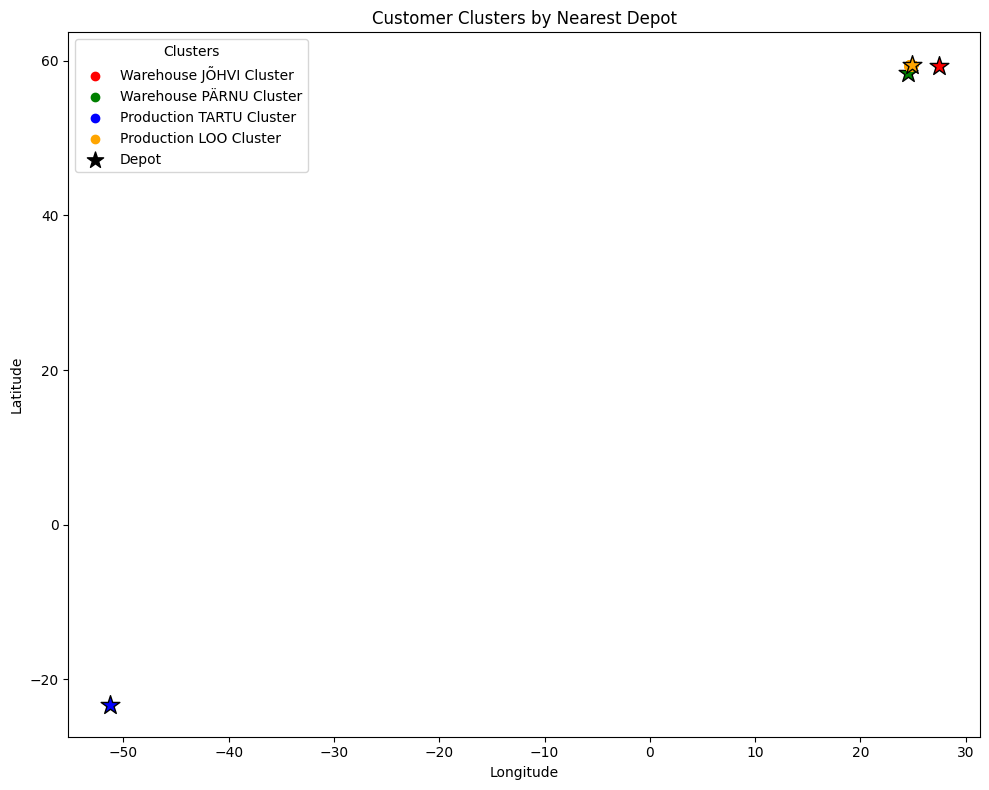


Depot-Centered Cluster Summary:
   cluster_id    cluster_name  customer_count  avg_distance_km  \
0           1  Production LOO             885        12.433753   

   max_distance_km  total_delivery_qty  total_weight  
0        23.003461              3568.0       9950.83  


In [9]:
# === Step 3: Clustering Approach Selection ===
print("\nSelect your clustering approach:")
print("1. Assign customers to nearest existing depot (depot-centered approach)")
print("2. Determine optimal clusters based on customer locations (customer-centered approach)")

import os
os.environ["LOKY_MAX_CPU_COUNT"] = "1"

while True:
    clustering_approach = input("Enter your choice (1 or 2): ").strip()
    if clustering_approach in ["1", "2"]:
        break
    print("Invalid choice. Please enter 1 or 2.")

# Store the selected file path for reuse
selected_file = file_path  # This uses the file_path you selected earlier

# Load the data using the same file you've already processed
df = pd.read_csv(selected_file, encoding=encoding, sep=chosen_delim)

# Filter out rows with missing coordinates
df = df.dropna(subset=['latitude', 'longitude']).copy()

if clustering_approach == "1":
    # === APPROACH 1: DEPOT-CENTERED CLUSTERING ===
    print("\nApproach 1: Assigning each address to the nearest depot cluster...")
    
    # Identify depot locations as fixed cluster centers
    depots_df = df[df['is_depot'] == True].copy().reset_index(drop=True)
    
    if len(depots_df) == 0:
        print("No depots found in the dataset. Please ensure there are records with 'is_depot' = True")
        sys.exit(1)
    
    # For each non-depot address, find the nearest depot using haversine distance
    # Prepare arrays of coordinates for vectorized distance computation
    non_depots_df = df[df['is_depot'] == False].copy()
    lat1 = np.radians(non_depots_df['latitude'].to_numpy())[:, None]   # shape (N,1)
    lon1 = np.radians(non_depots_df['longitude'].to_numpy())[:, None]  # shape (N,1)
    lat2 = np.radians(depots_df['latitude'].to_numpy())[None, :]       # shape (1,M)
    lon2 = np.radians(depots_df['longitude'].to_numpy())[None, :]      # shape (1,M)
    
    # Haversine formula to compute distance matrix between each non-depot and each depot (in kilometers)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    dist_matrix = 6371.0 * c  # Earth radius ~6371 km
    
    # Get index of nearest depot (smallest distance) for each non-depot address
    nearest_depot_idx = dist_matrix.argmin(axis=1)
    
    # Calculate the actual distances to nearest depot (in km)
    min_distances = np.min(dist_matrix, axis=1)
    
    # Create a new dataframe with only non-depot records, but include depot information
    result_df = non_depots_df.copy()
    
    # Add cluster information
    result_df['cluster_id'] = depots_df['depot_id'].iloc[nearest_depot_idx].values
    result_df['cluster_name'] = depots_df['depot_name'].iloc[nearest_depot_idx].values
    result_df['distance_to_depot_km'] = min_distances
    
    # Now add depot location information as additional columns for each row
    # This makes it easier to use the data for route optimization
    for col in ['latitude', 'longitude', 'formatted_address', 'geocode_confidence']:
        if col in depots_df.columns:
            new_col_name = f'depot_{col}'
            result_df[new_col_name] = depots_df[col].iloc[nearest_depot_idx].values
    
    # Ensure column types are appropriate and remove unwanted columns
    if 'cluster_id' in result_df.columns and result_df['cluster_id'].notna().any():
        result_df['cluster_id'] = result_df['cluster_id'].astype(int)
    
    # Remove unwanted columns
    columns_to_drop = [
        'is_depot', 'depot_id', 'depot_name', 'depot_address',  # Legacy columns
        'depot_is_depot', 'depot_depot_id', 'depot_depot_name', 'depot_depot_address'  # Redundant depot columns
    ]
    
    for col in columns_to_drop:
        if col in result_df.columns:
            result_df = result_df.drop(columns=[col])

    # Add empty route planning columns
    empty_columns = [
        'total_net_weight_per_route',
        'total_distance_per_route',
        'total_time_per_route',
        'delivery_time_window',
        'new_main_route_no',
        'new_route_no',
        'route_position',
        'route_distance_from_last_stop',
        'travel_time_from_last_stop',
        'new_total_distance_per_route',
        'new_total_time_per_route',
    ]

    # Extract middle digits from Route Number for main_route_no
    result_df['main_route_no'] = result_df['Route Number'].apply(extract_middle_digits)

    # Extract first digit from Route Number to determine delivery weekday
    result_df['delivery_weekday'] = result_df['Route Number'].apply(get_delivery_weekday)
    
    # Calculate service time based on Net Weight
    result_df['service_time_min'] = result_df['Net Weight'] * 0.95
    
    # Round service time to 2 decimal places for better readability
    result_df['service_time_min'] = result_df['service_time_min'].round(2)
    
    # For any zero weights, set a minimum service time (e.g., 1 minute)
    result_df.loc[result_df['service_time_min'] < 1, 'service_time_min'] = 1.0

    print(f"Service time calculation complete. Average service time: {result_df['service_time_min'].mean():.2f} minutes")
    
    for col in empty_columns:
        result_df[col] = None

    # Export the depot-centered clustered dataset to CSV
    result_df.to_csv(output_path / "03_1_depot_centered_clusters.csv", index=False)
    print(f"Depot-centered cluster assignment complete. Saved {len(result_df)} customer records.")
    
    # Visualize depot-centered clusters on a scatter plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define a color for each cluster (cycling if more clusters than colors)
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'olive', 'cyan', 'magenta']
    if len(depots_df) > len(colors):
        cmap = plt.cm.get_cmap('tab20', len(depots_df))
        colors = [cmap(i) for i in range(len(depots_df))]
    
    # Plot each cluster: customers as circles, depot as a distinct marker (star)
    for idx, depot in depots_df.iterrows():
        cluster_id = int(depot['depot_id'])
        cluster_name = depot['depot_name']
        
        # Select all addresses assigned to this cluster
        cluster_points = result_df[result_df['cluster_id'] == cluster_id]
        
        # Choose a color for this cluster
        color = colors[idx % len(colors)]
        
        # Plot customer addresses for this cluster
        ax.scatter(cluster_points['longitude'], cluster_points['latitude'],
                   color=color, marker='o', label=f"{cluster_name} Cluster")
        
        # Plot the depot location with a star marker
        ax.scatter(depot['longitude'], depot['latitude'], 
                   color=color, marker='*', s=200, edgecolors='black')
    
    # Add legend (one entry per cluster color, plus one for depot marker)
    # Create a dummy handle for depot to show in legend
    depot_handle = ax.scatter([], [], marker='*', color='k', s=150, edgecolors='black', label='Depot')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title="Clusters", loc='best')
    
    # Add axis labels and title
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title("Customer Clusters by Nearest Depot")
    
    plt.tight_layout()
    plt.show()
    
    # Optional: Create a summary of depot-centered clusters
    print("\nDepot-Centered Cluster Summary:")
    cluster_summary = result_df.groupby(['cluster_id', 'cluster_name']).agg(
        customer_count=('ABS Custumer no', 'count'),
        avg_distance_km=('distance_to_depot_km', 'mean'),
        max_distance_km=('distance_to_depot_km', 'max'),
        total_delivery_qty=('DeliveryQty', 'sum'),
        total_weight=('Net Weight', 'sum')
    ).reset_index()
    
    print(cluster_summary)

else:
    # === APPROACH 2: CUSTOMER-CENTERED CLUSTERING ===
    print("\nApproach 2: Determining optimal clusters based on customer locations...")
    
    # [The rest of the option 2 code remains unchanged]
    # Extract non-depot data for clustering if the column exists
    if 'is_depot' in df.columns:
        customers_df = df[df['is_depot'] == False].copy().reset_index(drop=True)
        if customers_df.empty:
            print("No customer data found. Using all locations as potential customers.")
            customers_df = df.copy().reset_index(drop=True)
    else:
        print("No 'is_depot' column found. Using all locations as potential customers.")
        customers_df = df.copy().reset_index(drop=True)
    
    # Extract coordinates for clustering
    X = customers_df[['latitude', 'longitude']].values
    
    # Scale the data to standardize latitude and longitude values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # 1. Determine the optimal number of clusters using the Elbow Method
    max_clusters = min(10, len(X) - 1)  # Maximum number of clusters to try
    if max_clusters < 2:
        print("Not enough data points for clustering. At least 3 points needed.")
        sys.exit(1)
    
    inertia = []
    K_range = range(1, max_clusters + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)
    
    # Plot the Elbow Method curve
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertia, 'o-', markersize=8, markerfacecolor='blue')
    plt.grid(True)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
    plt.title('Elbow Method for Optimal k', fontsize=14)
    
    # Use knee/elbow detection to find the optimal number of clusters
    try:
        kneedle = KneeLocator(K_range, inertia, curve='convex', direction='decreasing')
        optimal_k = kneedle.elbow
        plt.axvline(x=optimal_k, color='red', linestyle='--', 
                    label=f'Optimal k = {optimal_k}')
        plt.legend()
    except:
        # If automatic detection fails, use a heuristic
        optimal_k = 3  # Default if detection fails
        for i in range(1, len(inertia)-1):
            if (inertia[i-1] - inertia[i]) > 2 * (inertia[i] - inertia[i+1]):
                optimal_k = i + 1
                break
        plt.axvline(x=optimal_k, color='red', linestyle='--', 
                    label=f'Suggested k = {optimal_k}')
        plt.legend()
    
    plt.show()
    
    # Allow user to override the automatically detected k
    while True:
        user_k = input(f"Optimal number of clusters detected: {optimal_k}. Enter to accept or specify a different value: ").strip()
        if not user_k:
            # User accepts suggested value
            break
        try:
            user_k = int(user_k)
            if 2 <= user_k <= max_clusters:
                optimal_k = user_k
                break
            print(f"Please enter a value between 2 and {max_clusters}.")
        except ValueError:
            print("Please enter a valid number.")
    
    # 2. Perform K-means clustering with the optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Get cluster centers and transform back to original scale
    cluster_centers_scaled = kmeans.cluster_centers_
    cluster_centers = scaler.inverse_transform(cluster_centers_scaled)
    
    print(f"Shape of cluster_centers: {cluster_centers.shape}, optimal_k: {optimal_k}")
    
    # Ensure we have the correct number of cluster centers
    if cluster_centers.shape[0] != optimal_k:
        print(f"Warning: Expected {optimal_k} cluster centers but got {cluster_centers.shape[0]}. Fixing...")
        cluster_centers = cluster_centers[:optimal_k]
    
    # Add cluster information to the customer dataframe
    customers_df['cluster_id'] = cluster_labels + 1  # 1-based cluster IDs
    customers_df['cluster_name'] = customers_df['cluster_id'].apply(lambda x: f"Cluster {x}")
    
    # Calculate distance to cluster center (in km) and store cluster center coordinates
    customers_df['distance_to_depot_km'] = 0.0
    customers_df['depot_latitude'] = 0.0
    customers_df['depot_longitude'] = 0.0
    customers_df['depot_formatted_address'] = "Generated cluster center"
    
    for i, row in customers_df.iterrows():
        cluster_idx = int(row['cluster_id']) - 1
        center_lat, center_lon = cluster_centers[cluster_idx]
        
        # Store the cluster center coordinates
        customers_df.at[i, 'depot_latitude'] = center_lat
        customers_df.at[i, 'depot_longitude'] = center_lon
        
        # Calculate haversine distance
        lat1, lon1 = np.radians(row['latitude']), np.radians(row['longitude'])
        lat2, lon2 = np.radians(center_lat), np.radians(center_lon)
        
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        distance = 6371.0 * c  # Earth radius in km
        
        customers_df.at[i, 'distance_to_depot_km'] = distance
    
    # Remove unwanted columns if they exist
    columns_to_drop = [
        'depot_id', 'depot_name', 'depot_address',  # Legacy columns
        'depot_is_depot', 'depot_depot_id', 'depot_depot_name', 'depot_depot_address'  # Redundant depot columns
    ]
    
    for col in columns_to_drop:
        if col in customers_df.columns:
            customers_df = customers_df.drop(columns=[col])

    # Add empty route planning columns
    empty_columns = [
        'total_net_weight_per_route',
        'total_distance_per_route',
        'total_time_per_route',
        'delivery_time_window',
        'new_main_route_no',
        'new_route_no', 
        'route_position',
        'route_distance_from_last_stop',
        'travel_time_from_last_stop',
        'new_total_distance_per_route',
        'new_total_time_per_route',

    ]

    # Extract middle digits from Route Number for main_route_no
    customers_df['main_route_no'] = customers_df['Route Number'].apply(extract_middle_digits)

    # Extract first digit from Route Number to determine delivery weekday
    customers_df['delivery_weekday'] = customers_df['Route Number'].apply(get_delivery_weekday)

    # Calculate service time based on Net Weight
    customers_df['service_time_min'] = customers_df['Net Weight'] * 0.95

    # Round service time to 2 decimal places for better readability
    customers_df['service_time_min'] = customers_df['service_time_min'].round(2)

    # For any zero weights, set a minimum service time (e.g., 1 minute)
    customers_df.loc[customers_df['service_time_min'] < 1, 'service_time_min'] = 1.0

    print(f"Service time calculation complete. Average service time: {customers_df['service_time_min'].mean():.2f} minutes")
    
    for col in empty_columns:
        customers_df[col] = None

    # Export the customer-centered clustered dataset to a single CSV
    customers_df.to_csv(output_path / "03_2_customer_centered_clusters.csv", index=False)
    print(f"Customer-centered cluster assignment complete. Created {optimal_k} clusters.")
    print(f"Saved {len(customers_df)} customer records with their assigned optimal clusters.")
    
    # 3. Visualize the clusters on a scatter plot
    plt.figure(figsize=(12, 8))
    
    # Define a color for each cluster
    colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
    
    # Plot each cluster and its center
    for cluster_id in range(1, optimal_k + 1):
        # Plot points belonging to this cluster
        cluster_data = customers_df[customers_df['cluster_id'] == cluster_id]
        plt.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                    color=colors[cluster_id-1], marker='o', s=50, alpha=0.7,
                    label=f'Cluster {cluster_id} ({len(cluster_data)} customers)')
        
        # Plot cluster center (depot)
        center_idx = cluster_id - 1
        center_lat, center_lon = cluster_centers[center_idx]
        plt.scatter(center_lon, center_lat,
                   color=colors[center_idx], marker='*', s=300, edgecolors='black')
    
    plt.grid(True, alpha=0.3)
    plt.title(f'K-means Clustering (k={optimal_k}) - Optimal Depot Locations', fontsize=14)
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Print cluster summary
    print("\nCluster Summary:")
    cluster_summary = customers_df.groupby(['cluster_id', 'cluster_name']).agg(
        customer_count=('ABS Custumer no', 'count'),
        avg_distance_km=('distance_to_depot_km', 'mean'),
        max_distance_km=('distance_to_depot_km', 'max'),
        total_delivery_qty=('DeliveryQty', 'sum'),
        total_weight=('Net Weight', 'sum')
    ).reset_index()
    
    print(cluster_summary)
    
    print("\nOptimal Depot Locations (Cluster Centers):")
    for i in range(optimal_k):
        print(f"Cluster {i+1}: Latitude={cluster_centers[i][0]:.6f}, Longitude={cluster_centers[i][1]:.6f}")

### 1. Why This Number of Clusters Was Chosen

After applying the Elbow Method, the plot showed a clear "elbow" at k = 3.
This point indicates that increasing the number of clusters beyond '3' results in only marginal improvements in compactness (inertia).
Therefore, choosing k = 3 balances model simplicity and clustering quality, avoiding overfitting or unnecessary fragmentation of the data.

---

### 2. Do the Clusters Make Sense?
The resulting clusters appear to make logical sense based on the geographical distribution of customers.
Customers grouped into the same cluster are geographically close to each other, which supports the objective of creating efficient delivery routes.

No major outliers were observed within clusters, and the cluster centers (depots) are located reasonably close to their associated customers.

If needed, further fine-tuning could be considered, such as adjusting the number of clusters slightly or adding business-specific rules (e.g., capacity limits).

---